In [2]:
import os
os.getcwd()

'/home/ubuntu/NCI/notebooks'

In [3]:
import os
os.chdir("/home/ubuntu/NCI")
os.getcwd()

'/home/ubuntu/NCI'

In [4]:
import json
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

plt.rc('font', family='serif')

params = {
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
}
plt.rcParams.update(params)
pd.set_option("display.precision", 4)
pd.options.display.float_format = '{:,.4f}'.format


color_list = list(mcolors.TABLEAU_COLORS)

# INIT

In [5]:
task = "nc"
data_suffix = "baseline"
base_folder = f"./data"

In [6]:
datasets = {
    'Cora': 'Cora',
}

data_order = {
    'Cora': 1,
}

rel_formal_names = {
    "attr": "Attr",
    "attr_dist": "1-Attr",
    "common_neighbor": "JS",
    "degree_dist": "1-Deg",
    "g_dist": "SPD",
    "has_link": "Link",
    "label_dist": "1-Label",
    "pagerank": "PR"
}

model_formal_names = {
    "random": "Random",
    "gcn": "GCN",
}

model_order = {
    "random": 0,
    "Cantelli's UB": 1,
    "gcn": 4,
}

relation_order = {
    "Link": 0,
    "SPD": 1, 
    "JS": 2,
    "PR": 3,
    "1-Deg": 4,
    "1-Label": 5,
    "Attr": 6,
    "1-Attr": 7,
}

# Intrinsic Evaluation 

## Intrusion Test

In [7]:
data_df = pd.DataFrame()
for dataset_name in datasets:
    test_config = json.load(open(f"./config/{dataset_name}_coherence_test.json", "r"))
    for data_suffix in test_config["semantic_relation"]:
        for similarity in test_config["semantic_relation"][data_suffix]:
            if similarity[:-1]!="random":
                for model in test_config[task][data_suffix]:
                    # if model=="random":
                    #     continue
                    for model_suffix in test_config[task][data_suffix][model]:
                        df = pd.read_csv(f"{base_folder}/{dataset_name}/exp/{similarity}_{task}_{dataset_name}_{data_suffix}_{model}_{model_suffix}.csv", index_col=0)
                        model_name = model
                        df["order"] = [model_order[model_name]] * len(df)
                        df["Encoder"] = [model_name] * len(df)
                        df["Dataset"] = [datasets[dataset_name]] * len(df)
                        df["encoder_name"] = [model_formal_names[model_name]] * len(df)
                        df["Relation"] = [rel_formal_names[similarity]] * len(df)
                        data_df = pd.concat((data_df, df))
                df = pd.read_csv(f"{base_folder}/{dataset_name}/exp/{similarity}_{task}_{dataset_name}_{data_suffix}_random_baseline.csv", index_col=0)
                model_name = f"Cantelli's UB"
                df["order"] = [model_order[model_name]] * len(df)
                df["Encoder"] = [model_name] * len(df)
                df["encoder_name"] = [model_name] * len(df)
                df["Dataset"] = [datasets[dataset_name]] * len(df)
                df["Relation"] = [rel_formal_names[similarity]] * len(df)
                df["Group Coherence Rate"] = df["Intrusion Upper Bound"]
                data_df = pd.concat((data_df, df))
data_df = data_df.reset_index(drop=True)
data_df["rel_order"] = data_df["Relation"].apply(lambda x: relation_order[x])
data_df = data_df.sort_values(by=["order", "rel_order"])
colors = [color_list[m] for m in data_df.order.unique()]
data_df["Coherence Rate"] = data_df[["Group Coherence Rate", "Rank Coherence Rate"]].mean(axis=1)

/tmp/ipykernel_19346/896116629.py:12: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(data=data_df[(data_df["Dataset"]==name)&conditions], x="Relation", y="Coherence Rate", hue="encoder_name", ax=axes, palette=colors)


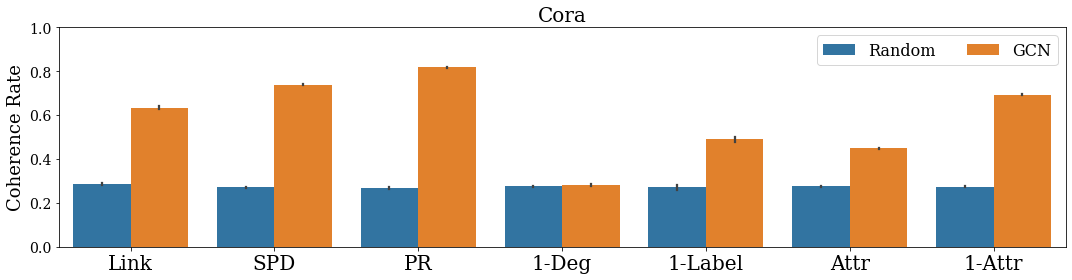

In [8]:
fig, axes = plt.subplots(1, 1,figsize=(15, 4), sharex=True, sharey=True)
i = 0
conditions = (
    data_df["encoder_name"]!="Cantelli's UB"
)

datasets = {
    'Cora': 'Cora',
}
for dataset_name in datasets:
    name = datasets[dataset_name]
    sns.barplot(data=data_df[(data_df["Dataset"]==name)&conditions], x="Relation", y="Coherence Rate", hue="encoder_name", ax=axes, palette=colors)
    axes.set_ylabel("Coherence Rate")
    axes.set_xlabel(None)
    axes.set_ylim(0,1)
    axes.set_title(datasets[dataset_name])
    axes.legend(ncol=len(model_name))
    plt.tight_layout()
    i+=1
plt.savefig(f"{task}_homo_coherence_half.pdf", dpi=300)